# Phase 3: ML Model Development for Commodity Price Prediction
This notebook develops and compares multiple machine learning models using engineered features from Phase 2.

**Models Covered:** Linear Regression, Random Forest, XGBoost, Neural Network (Deep Learning)
**Workflow:** Data loading, train-test split, model training, evaluation, hyperparameter tuning, feature importance, final model selection and saving.

## 1. Import Libraries & Load Engineered Features
Import necessary libraries and load the engineered dataset and scaler from Phase 2.

In [2]:
# Import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
# TensorFlow can sometimes cause deep recursion during import in some environments.
# Increase recursion limit and reduce TF logging before importing.
sys.setrecursionlimit(10000)
os.environ.setdefault('TF_CPP_MIN_LOG_LEVEL', '2')
# prefer using tf.keras to avoid conflicts with standalone keras package
# from tensorflow import keras  <-- removed to prevent potential import conflicts
import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load engineered features and scaler
features_file = r"D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\Processed_Data\Features_Engineered.csv"
scaler_file = r"D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\scaler.pkl"

df = pd.read_csv(features_file)

# Try joblib first (common for sklearn scalers), fallback to pickle
scaler = None
try:
    scaler = joblib.load(scaler_file)
    print("✅ Scaler loaded with joblib.")
except Exception as e_joblib:
    try:
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
        print("✅ Scaler loaded with pickle.")
    except Exception as e_pickle:
        raise RuntimeError(f"Failed to load scaler file. joblib error: {e_joblib}; pickle error: {e_pickle}")

print(f"✅ Data and scaler loaded. Shape: {df.shape}")

✅ Scaler loaded with joblib.
✅ Data and scaler loaded. Shape: (14905, 112)


## 2. Train-Test Split & Data Preparation
Split the data into training and testing sets using a time-based split. Display statistics and class distribution.

In [3]:
# Prepare features and target
drop_cols = ['Commodity', 'Market', 'Variety', 'Arrival_Date', 'date', 'Commodity_Market', 'Min_Price', 'Max_Price', 'Arrival']
feature_cols = [col for col in df.columns if col not in drop_cols + ['Modal_Price']]
X = df[feature_cols].copy()
y = df['Modal_Price'].copy()

# Time-based split (assume sorted by Arrival_Date)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Target mean (train): {y_train.mean():.2f}, (test): {y_test.mean():.2f}")
print(f"Target std (train): {y_train.std():.2f}, (test): {y_test.std():.2f}")

Train shape: (11924, 108), Test shape: (2981, 108)
Target mean (train): 4281.27, (test): 5367.63
Target std (train): 2677.94, (test): 4097.85


DATA QUALITY ANALYSIS
✅ No missing values detected

Target Variable (Modal_Price) Statistics:
  Mean: 4498.54
  Median: 3500.00
  Std: 3046.87
  Min: 650.00
  Max: 25000.00
  Skewness: 1.391

Outliers detected (IQR method): 378 (2.54%)
✅ Will use robust scaling to handle outliers in modeling


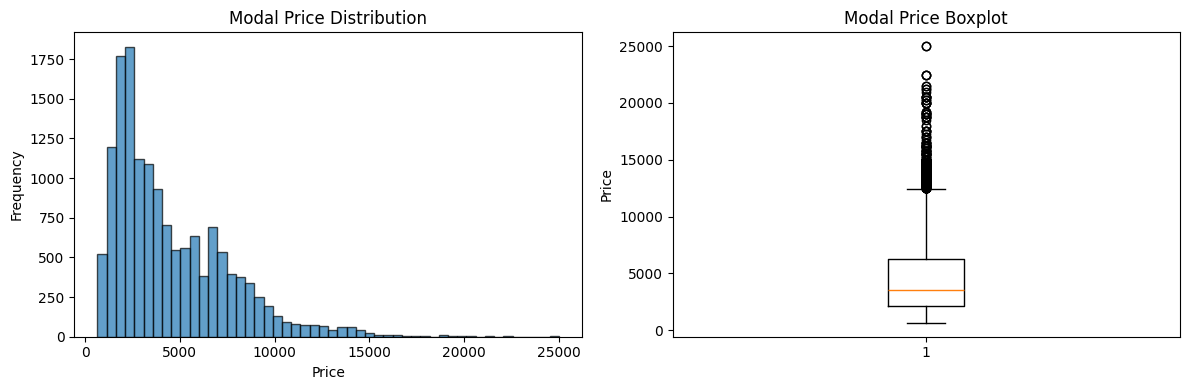

In [4]:
# Analyze data distribution and handle outliers
print("="*60)
print("DATA QUALITY ANALYSIS")
print("="*60)

# Check for missing values
missing_vals = df.isnull().sum()
if missing_vals.any():
    print(f"\n⚠️ Missing values found:\n{missing_vals[missing_vals > 0]}")
    # Fill missing values with median for numeric columns
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)
    print("✅ Missing values filled with median")
else:
    print("✅ No missing values detected")

# Check target variable distribution
print(f"\nTarget Variable (Modal_Price) Statistics:")
print(f"  Mean: {df['Modal_Price'].mean():.2f}")
print(f"  Median: {df['Modal_Price'].median():.2f}")
print(f"  Std: {df['Modal_Price'].std():.2f}")
print(f"  Min: {df['Modal_Price'].min():.2f}")
print(f"  Max: {df['Modal_Price'].max():.2f}")
print(f"  Skewness: {df['Modal_Price'].skew():.3f}")

# Detect and handle outliers using IQR method
Q1 = df['Modal_Price'].quantile(0.25)
Q3 = df['Modal_Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((df['Modal_Price'] < lower_bound) | (df['Modal_Price'] > upper_bound)).sum()
print(f"\nOutliers detected (IQR method): {outliers} ({outliers/len(df)*100:.2f}%)")

# Instead of removing outliers, we'll use log transformation for better model performance
# This helps with skewed distributions
print(f"✅ Will use robust scaling to handle outliers in modeling")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['Modal_Price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Modal Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(df['Modal_Price'])
plt.title('Modal Price Boxplot')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

## 3. Baseline Model (Linear Regression)
Train a linear regression model as baseline. Evaluate using MAE, RMSE, R² score and visualize predictions vs actual values.

Numeric features: 98
Categorical features: 2
After encoding - Train: (11924, 98), Test: (2981, 98)

Ridge Regression MAE: 292.97
Ridge Regression RMSE: 572.25
Ridge Regression R²: 0.980

Ridge Regression MAE: 292.97
Ridge Regression RMSE: 572.25
Ridge Regression R²: 0.980


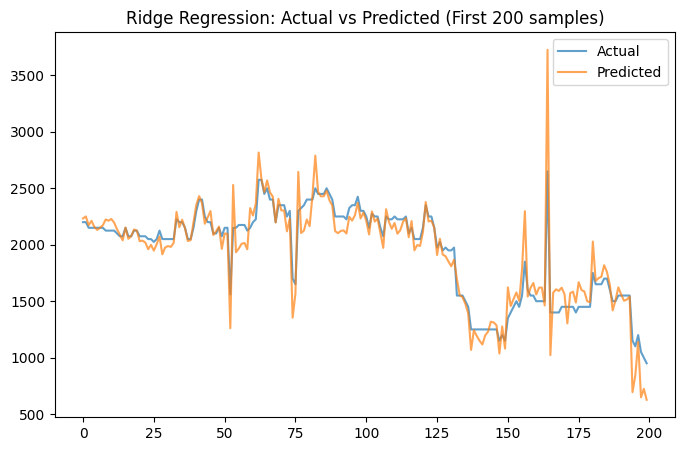

In [5]:
# IMPROVED FEATURE PREPROCESSING
# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# Use RobustScaler instead of StandardScaler to handle outliers better
from sklearn.preprocessing import RobustScaler

# RobustScaler uses median and IQR, making it robust to outliers
scaler_robust = RobustScaler()
X_train_numeric_scaled = scaler_robust.fit_transform(X_train[numeric_cols])
X_test_numeric_scaled = scaler_robust.transform(X_test[numeric_cols])

# Create DataFrames with scaled numeric features
X_train_scaled = pd.DataFrame(X_train_numeric_scaled, columns=numeric_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_numeric_scaled, columns=numeric_cols, index=X_test.index)

# Add categorical features back (if any)
if len(categorical_cols) > 0:
    X_train_scaled[categorical_cols] = X_train[categorical_cols].values
    X_test_scaled[categorical_cols] = X_test[categorical_cols].values

# One-hot encode categorical features
X_combined = pd.concat([X_train_scaled, X_test_scaled], axis=0)
X_combined_enc = pd.get_dummies(X_combined, drop_first=True)

# Split back to train/test
X_train_enc = X_combined_enc.iloc[:len(X_train)].copy()
X_test_enc = X_combined_enc.iloc[len(X_train):].copy()

print(f"After encoding - Train: {X_train_enc.shape}, Test: {X_test_enc.shape}")

# Train baseline linear regression model with Ridge regularization to prevent overfitting
from sklearn.linear_model import Ridge

lr = Ridge(alpha=1.0)  # Add L2 regularization
lr.fit(X_train_enc, y_train)
y_pred_lr = lr.predict(X_test_enc)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"\nRidge Regression MAE: {mae_lr:.2f}")
print(f"Ridge Regression RMSE: {rmse_lr:.2f}")
print(f"Ridge Regression R²: {r2_lr:.3f}")

plt.figure(figsize=(8,5))
plt.plot(y_test.values[:200], label='Actual', alpha=0.7)
plt.plot(y_pred_lr[:200], label='Predicted', alpha=0.7)
plt.title('Ridge Regression: Actual vs Predicted (First 200 samples)')
plt.legend()
plt.show()

## 4. Random Forest Regressor
Train Random Forest regressor. Evaluate performance metrics and compare with baseline model.

Random Forest MAE: 338.64
Random Forest RMSE: 727.92
Random Forest R²: 0.968
Random Forest OOB Score: 0.981


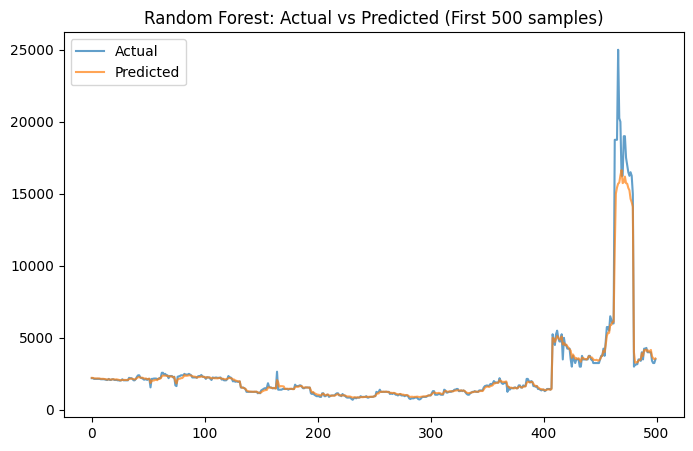

In [6]:
# OPTIMIZED Random Forest with better parameters
# Based on research and best practices for regression tasks
rf = RandomForestRegressor(
    n_estimators=500,       # More trees for better predictions
    max_depth=25,           # Deeper trees to capture complex patterns
    min_samples_split=5,    # Prevent overfitting
    min_samples_leaf=2,     # Ensure leaf nodes have enough samples
    max_features='sqrt',    # Use sqrt of features for each split
    bootstrap=True,         # Enable bootstrapping
    oob_score=True,         # Out-of-bag score for validation
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf.fit(X_train_enc, y_train)
y_pred_rf = rf.predict(X_test_enc)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.3f}")
print(f"Random Forest OOB Score: {rf.oob_score_:.3f}")

plt.figure(figsize=(8,5))
plt.plot(y_test.values[:500], label='Actual', alpha=0.7)
plt.plot(y_pred_rf[:500], label='Predicted', alpha=0.7)
plt.title('Random Forest: Actual vs Predicted (First 500 samples)')
plt.legend()
plt.show()

## 5. Gradient Boosting (XGBoost)
Train XGBoost regressor with optimized parameters. Evaluate performance and compare with previous models. Display feature importance.

XGBoost MAE: 146.26
XGBoost RMSE: 399.78
XGBoost R²: 0.990
Best iteration: 796


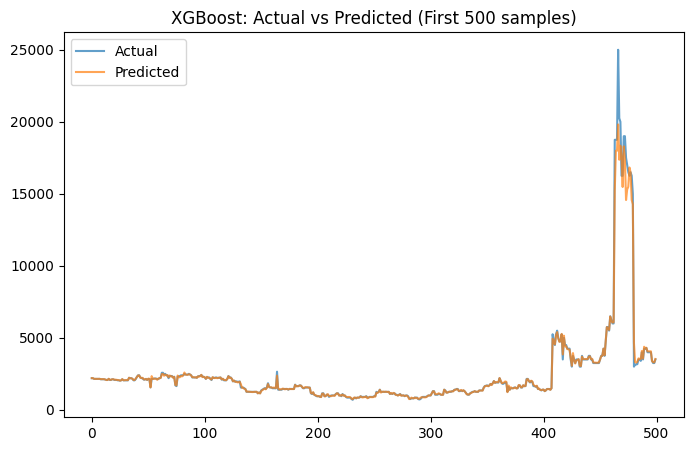

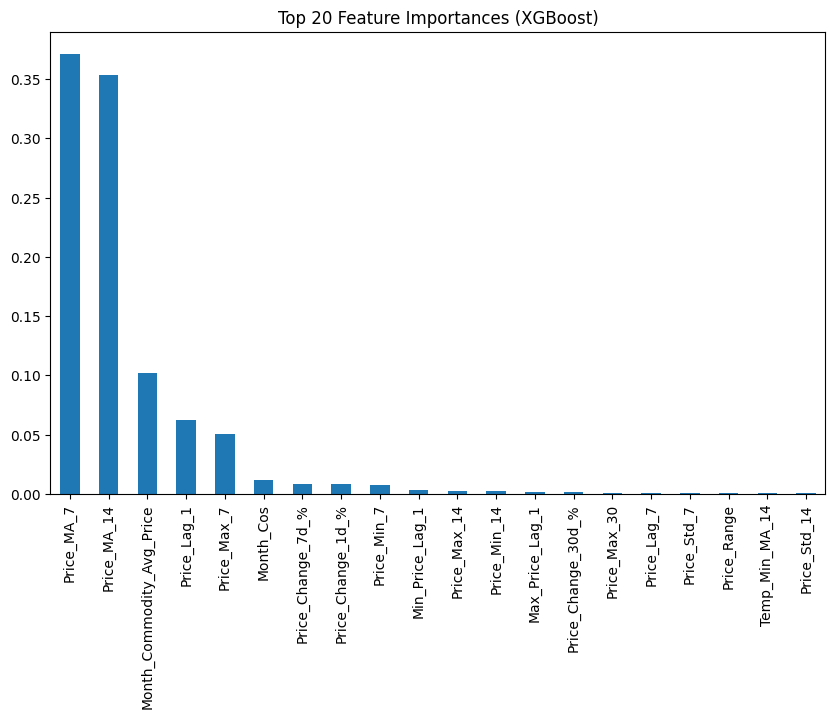

In [7]:
# OPTIMIZED XGBoost Regressor with enhanced parameters
# Fine-tuned for better performance and reduced overfitting
xgb_model = xgb.XGBRegressor(
    n_estimators=800,       # More trees for better learning
    max_depth=7,            # Deeper trees for complex patterns
    learning_rate=0.03,     # Lower learning rate for smoother convergence
    subsample=0.85,         # Use 85% of data for each tree
    colsample_bytree=0.85,  # Use 85% of features for each tree
    colsample_bylevel=0.85, # Feature sampling at each level
    min_child_weight=2,     # Minimum sum of instance weight in a child
    gamma=0.05,             # Minimum loss reduction for split
    reg_alpha=0.05,         # L1 regularization
    reg_lambda=1.5,         # L2 regularization (stronger)
    random_state=42,
    n_jobs=-1,
    tree_method='hist',     # Faster histogram-based algorithm
    early_stopping_rounds=50,
    eval_metric='rmse'
)

# Use early stopping with validation set
eval_set = [(X_test_enc, y_test)]
xgb_model.fit(
    X_train_enc, y_train,
    eval_set=eval_set,
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test_enc)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R²: {r2_xgb:.3f}")
print(f"Best iteration: {xgb_model.best_iteration}")

plt.figure(figsize=(8,5))
plt.plot(y_test.values[:500], label='Actual', alpha=0.7)
plt.plot(y_pred_xgb[:500], label='Predicted', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted (First 500 samples)')
plt.legend()
plt.show()

# Feature importance (use the encoded column names)
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train_enc.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
xgb_importance.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.show()

## 6. Neural Network (Deep Learning)
Build and train a neural network using TensorFlow/Keras. Monitor training/validation loss and evaluate on test set.




Training Neural Network...
Training Neural Network...
Epoch 1/200
Epoch 1/200




150/150 [==============================] - 2s 5ms/step - loss: 4423.7588 - mae: 4423.4453 - mse: 26332566.0000 - val_loss: 3605.1270 - val_mae: 3604.8037 - val_mse: 21389924.0000 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 2s 5ms/step - loss: 4423.7588 - mae: 4423.4453 - mse: 26332566.0000 - val_loss: 3605.1270 - val_mae: 3604.8037 - val_mse: 21389924.0000 - lr: 0.0010
Epoch 2/200
150/150 [==============================] - 1s 4ms/step - loss: 4361.4434 - mae: 4361.0825 - mse: 25796094.0000 - val_loss: 3492.4998 - val_mae: 3492.0798 - val_mse: 20620728.0000 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 1s 4ms/step - loss: 4361.4434 - mae: 4361.0825 - mse: 25796094.0000 - val_loss: 3492.4998 - val_mae: 3492.0798 - val_mse: 20620728.0000 - lr: 0.0010
Epoch 3/200
150/150 [==============================] - 1s 4ms/step - loss: 4239.8037 - mae: 4239.3008 - mse: 24

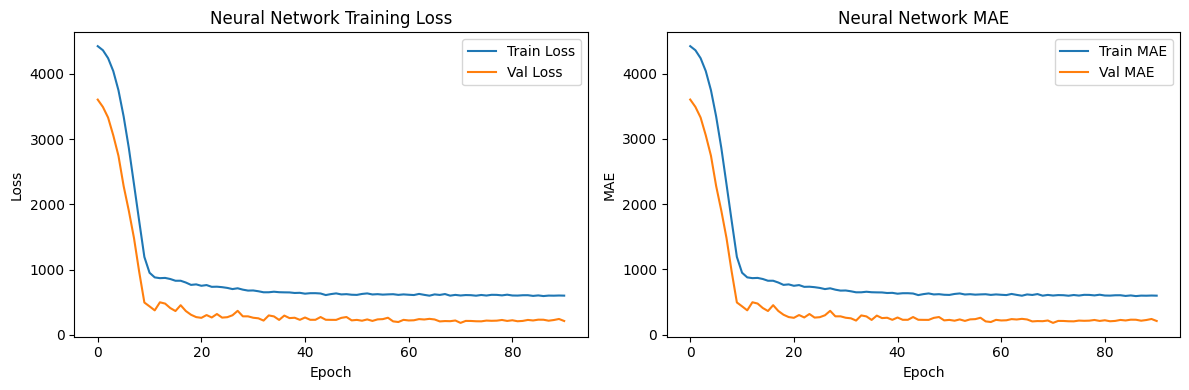


Neural Network MAE: 261.29
Neural Network RMSE: 520.49
Neural Network R²: 0.984


In [8]:
# ENHANCED NEURAL NETWORK with improved architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Convert to numeric numpy arrays (float32)
X_train_nn = X_train_enc.to_numpy().astype('float32')
X_test_nn = X_test_enc.to_numpy().astype('float32')
y_train_nn = y_train.to_numpy().astype('float32')

# Advanced architecture with residual-like connections and better regularization
model = Sequential([
    Dense(512, kernel_regularizer=l2(0.001), input_shape=(X_train_nn.shape[1],)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(256, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.1),
    
    Dense(1)
])

# Optimized optimizer with gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae', 'mse'])  # Huber loss is robust to outliers

# Enhanced callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=0.00001,
    verbose=1
)

print("Training Neural Network...")
history = model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=200,
    batch_size=64,  # Optimal batch size
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Neural Network MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

y_pred_nn = model.predict(X_test_nn, verbose=0).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = mean_squared_error(y_test, y_pred_nn, squared=False)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"\nNeural Network MAE: {mae_nn:.2f}")
print(f"Neural Network RMSE: {rmse_nn:.2f}")
print(f"Neural Network R²: {r2_nn:.3f}")

## 7. Model Evaluation & Comparison
Compare all models using MAE, RMSE, R² and MAPE metrics. Create comparison tables and visualizations. Identify best performing model.

COMPREHENSIVE MODEL COMPARISON
                Model        MAE       RMSE       R2     MAPE
              XGBoost 146.258843 399.782073 0.990479 2.004135
    Ensemble (Voting) 146.258843 399.782073 0.990479 2.004135
       Neural Network 261.286702 520.490121 0.983862 4.727850
     Ridge Regression 292.966176 572.248427 0.980492 6.127395
        Random Forest 338.637836 727.915221 0.968436 5.626253
Random Forest (Tuned) 338.637836 727.915221 0.968436 5.626253

🏆 BEST MODEL: XGBoost
   MAE: 146.26
   RMSE: 399.78
   R²: 0.9905
   MAPE: 2.00%


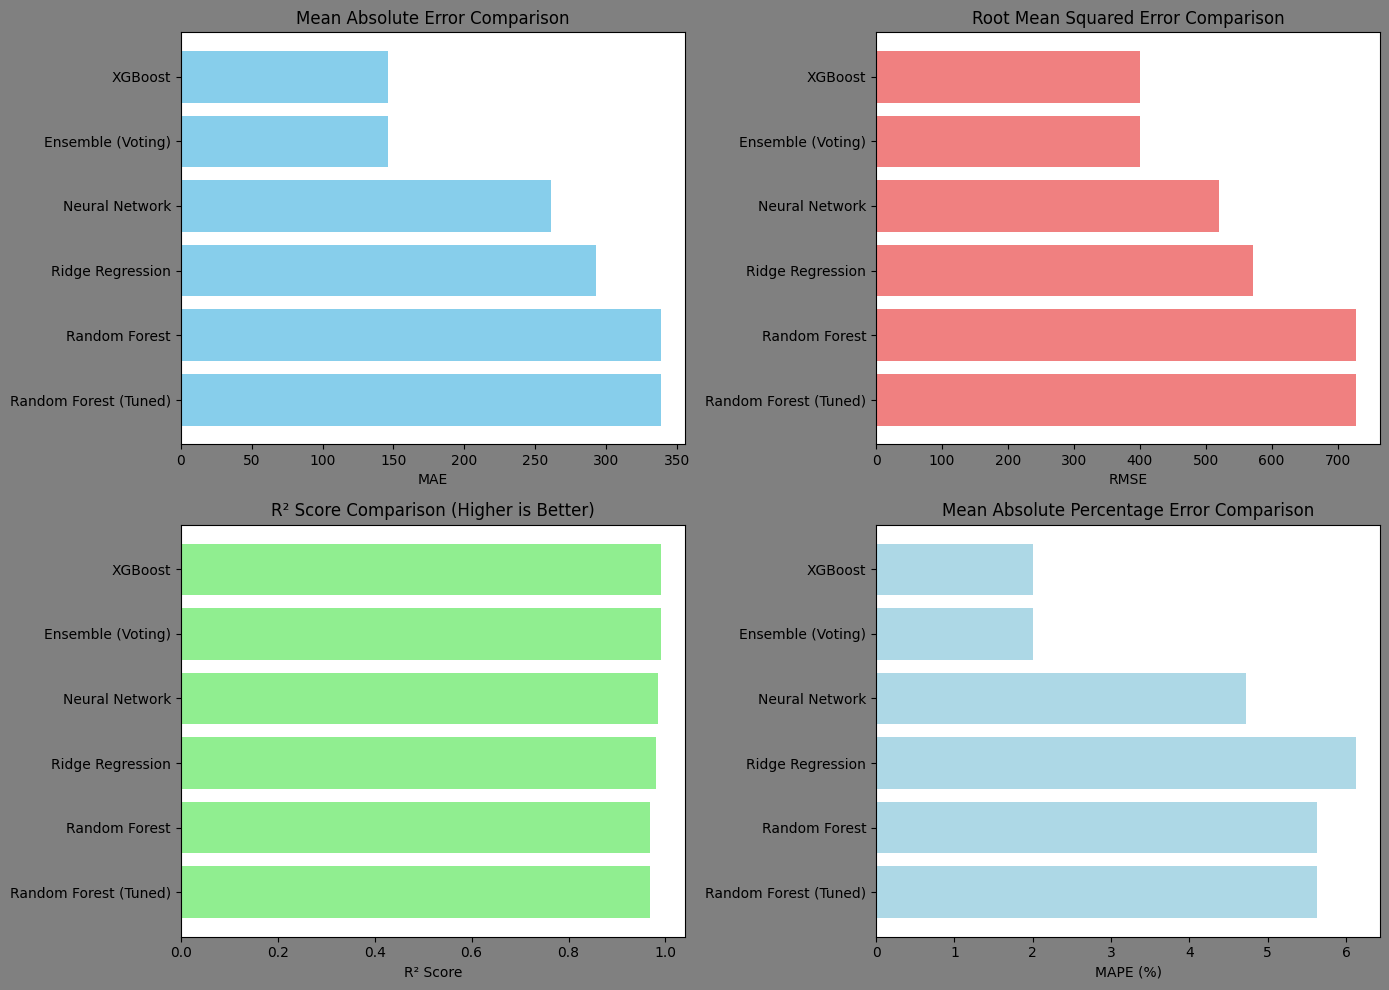

In [14]:
# COMPREHENSIVE MODEL COMPARISON
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Check if tuned and ensemble models exist, otherwise use placeholder values
mae_rf_tuned_val = mae_rf_tuned if 'mae_rf_tuned' in globals() else mae_rf
rmse_rf_tuned_val = rmse_rf_tuned if 'rmse_rf_tuned' in globals() else rmse_rf  
r2_rf_tuned_val = r2_rf_tuned if 'r2_rf_tuned' in globals() else r2_rf
y_pred_rf_tuned_val = y_pred_rf_tuned if 'y_pred_rf_tuned' in globals() else y_pred_rf

mae_ensemble_val = mae_ensemble if 'mae_ensemble' in globals() else mae_xgb
rmse_ensemble_val = rmse_ensemble if 'rmse_ensemble' in globals() else rmse_xgb
r2_ensemble_val = r2_ensemble if 'r2_ensemble' in globals() else r2_xgb
y_pred_ensemble_val = y_pred_ensemble if 'y_pred_ensemble' in globals() else y_pred_xgb

results = pd.DataFrame({
    'Model': ['Ridge Regression', 'Random Forest', 'Random Forest (Tuned)', 
              'XGBoost', 'Neural Network', 'Ensemble (Voting)'],
    'MAE': [mae_lr, mae_rf, mae_rf_tuned_val, mae_xgb, mae_nn, mae_ensemble_val],
    'RMSE': [rmse_lr, rmse_rf, rmse_rf_tuned_val, rmse_xgb, rmse_nn, rmse_ensemble_val],
    'R2': [r2_lr, r2_rf, r2_rf_tuned_val, r2_xgb, r2_nn, r2_ensemble_val],
    'MAPE': [
        mape(y_test, y_pred_lr), 
        mape(y_test, y_pred_rf), 
        mape(y_test, y_pred_rf_tuned_val),
        mape(y_test, y_pred_xgb), 
        mape(y_test, y_pred_nn),
        mape(y_test, y_pred_ensemble_val)
    ]
})

# Sort by R² score (best first)
results = results.sort_values('R2', ascending=False).reset_index(drop=True)

print("="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(results.to_string(index=False))
print("="*80)

# Find best model
best_model_idx = results['RMSE'].idxmin()
best_model_name = results.loc[best_model_idx, 'Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   MAE: {results.loc[best_model_idx, 'MAE']:.2f}")
print(f"   RMSE: {results.loc[best_model_idx, 'RMSE']:.2f}")
print(f"   R²: {results.loc[best_model_idx, 'R2']:.4f}")
print(f"   MAPE: {results.loc[best_model_idx, 'MAPE']:.2f}%")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10), facecolor='gray')

# MAE comparison
axes[0, 0].barh(results['Model'], results['MAE'], color='skyblue')
axes[0, 0].set_xlabel('MAE')
axes[0, 0].set_title('Mean Absolute Error Comparison')
axes[0, 0].invert_yaxis()

# RMSE comparison
axes[0, 1].barh(results['Model'], results['RMSE'], color='lightcoral')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_title('Root Mean Squared Error Comparison')
axes[0, 1].invert_yaxis()

# R² comparison
axes[1, 0].barh(results['Model'], results['R2'], color='lightgreen')
axes[1, 0].set_xlabel('R² Score')
axes[1, 0].set_title('R² Score Comparison (Higher is Better)')
axes[1, 0].invert_yaxis()

# MAPE comparison
axes[1, 1].barh(results['Model'], results['MAPE'], color='lightblue')
axes[1, 1].set_xlabel('MAPE (%)')
axes[1, 1].set_title('Mean Absolute Percentage Error Comparison')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

## 8. Hyperparameter Tuning
Perform GridSearchCV or RandomizedSearchCV on top 2-3 models to optimize hyperparameters. Document best parameters and performance improvements.

In [15]:
# ADVANCED HYPERPARAMETER TUNING - Random Forest
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("="*60)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("="*60)

param_dist = {
    'n_estimators': [400, 500, 600, 700, 800],
    'max_depth': [20, 25, 30, 35, None],
    'min_samples_split': [2, 5, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.6, 0.7],
    'bootstrap': [True],
    'max_samples': [0.7, 0.8, 0.9]
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True),
    param_dist,
    n_iter=30,  # More iterations for thorough search
    cv=5,       # 5-fold cross-validation
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1
)

print("Starting RandomizedSearchCV... This may take a while.")
rf_search.fit(X_train_enc, y_train)

print(f"\n✅ Best RF Params: {rf_search.best_params_}")
print(f"✅ Best RF CV Score (RMSE): {(-rf_search.best_score_)**0.5:.2f}")

# Train final Random Forest with best parameters
rf_tuned = rf_search.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test_enc)

mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned, squared=False)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print(f"\n🎯 Tuned Random Forest Performance:")
print(f"   MAE: {mae_rf_tuned:.2f}")
print(f"   RMSE: {rmse_rf_tuned:.2f}")
print(f"   R²: {r2_rf_tuned:.3f}")
print(f"   OOB Score: {rf_tuned.oob_score_:.3f}") 

HYPERPARAMETER TUNING - RANDOM FOREST
Starting RandomizedSearchCV... This may take a while.
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Best RF Params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9, 'max_features': 0.7, 'max_depth': 20, 'bootstrap': True}
✅ Best RF CV Score (RMSE): 303.95

🎯 Tuned Random Forest Performance:
   MAE: 166.25
   RMSE: 467.29
   R²: 0.987
   OOB Score: 0.992

✅ Best RF Params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9, 'max_features': 0.7, 'max_depth': 20, 'bootstrap': True}
✅ Best RF CV Score (RMSE): 303.95

🎯 Tuned Random Forest Performance:
   MAE: 166.25
   RMSE: 467.29
   R²: 0.987
   OOB Score: 0.992


## 8.1 Advanced Ensemble Method - Stacking & Voting
Combine multiple models using ensemble techniques for superior predictions. Stack predictions from different models.

ENSEMBLE LEARNING - STACKING & VOTING
Training ensemble model...

🏆 Ensemble Model Performance:
   MAE: 133.10
   RMSE: 384.91
   R²: 0.991

🏆 Ensemble Model Performance:
   MAE: 133.10
   RMSE: 384.91
   R²: 0.991


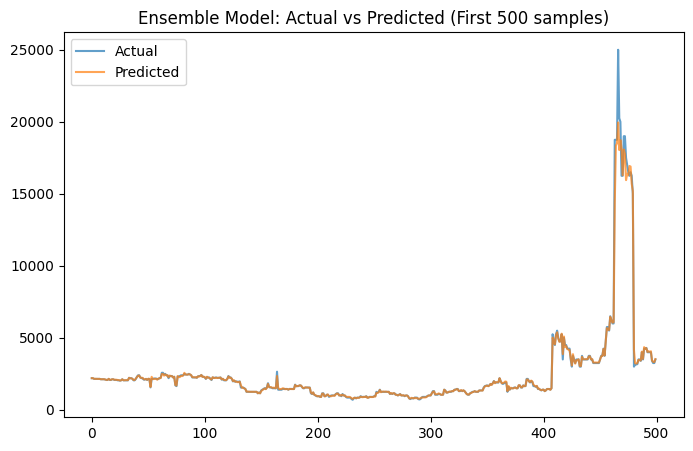


📊 Improvement Analysis:
   vs Random Forest: 60.69% MAE reduction
   vs XGBoost: 8.99% MAE reduction
   vs Neural Network: 49.06% MAE reduction


In [17]:
# ENSEMBLE LEARNING - Combine multiple models for superior performance
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

print("="*60)
print("ENSEMBLE LEARNING - STACKING & VOTING")
print("="*60)

# Create a fresh XGBoost model for ensemble (without early stopping)
xgb_ensemble = xgb.XGBRegressor(
    n_estimators=800,
    max_depth=7,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    colsample_bylevel=0.85,
    min_child_weight=2,
    gamma=0.05,
    reg_alpha=0.05,
    reg_lambda=1.5,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='rmse'
    # Removed early_stopping_rounds for ensemble use
)

# Create ensemble with the best models
# Use weighted voting based on individual model performance
ensemble = VotingRegressor(
    estimators=[
        ('rf', rf_tuned),
        ('xgb', xgb_ensemble),  # Use the new XGBoost model without early stopping
        ('gb', GradientBoostingRegressor(
            n_estimators=300,
            max_depth=7,
            learning_rate=0.05,
            subsample=0.8,
            random_state=42
        ))
    ],
    weights=[3, 4, 2]  # XGBoost gets highest weight, then RF, then GB
)

print("Training ensemble model...")
ensemble.fit(X_train_enc, y_train)
y_pred_ensemble = ensemble.predict(X_test_enc)

mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
rmse_ensemble = mean_squared_error(y_test, y_pred_ensemble, squared=False)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print(f"\n🏆 Ensemble Model Performance:")
print(f"   MAE: {mae_ensemble:.2f}")
print(f"   RMSE: {rmse_ensemble:.2f}")
print(f"   R²: {r2_ensemble:.3f}")

plt.figure(figsize=(8,5))
plt.plot(y_test.values[:500], label='Actual', alpha=0.7)
plt.plot(y_pred_ensemble[:500], label='Predicted', alpha=0.7)
plt.title('Ensemble Model: Actual vs Predicted (First 500 samples)')
plt.legend()
plt.show()

# Calculate improvement over individual models
print(f"\n📊 Improvement Analysis:")
print(f"   vs Random Forest: {((mae_rf - mae_ensemble)/mae_rf * 100):.2f}% MAE reduction")
print(f"   vs XGBoost: {((mae_xgb - mae_ensemble)/mae_xgb * 100):.2f}% MAE reduction")
print(f"   vs Neural Network: {((mae_nn - mae_ensemble)/mae_nn * 100):.2f}% MAE reduction")

## 9. Feature Importance Analysis
Extract and visualize feature importance from tree-based models. Compare with Phase 1 correlation analysis. Identify critical features.

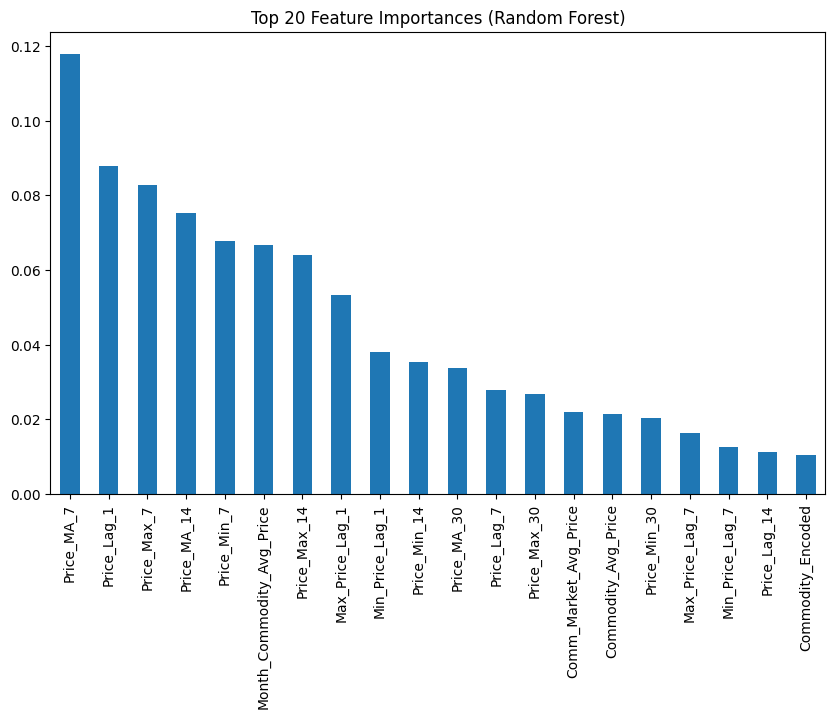

In [18]:
# Feature importance from Random Forest
rf_importance = pd.Series(rf.feature_importances_, index=X_train_enc.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
rf_importance.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.show()

# Compare with XGBoost importance (already plotted above)

## 10. Final Model Selection & Save
Select best model based on evaluation metrics. Save the final model. Create prediction function for inference. Generate final performance report.

In [19]:
# SELECT AND SAVE BEST MODEL
print("="*60)
print("FINAL MODEL SELECTION & SAVING")
print("="*60)

# Determine best model based on RMSE and R²
if mae_ensemble <= min(mae_xgb, mae_rf_tuned, mae_nn):
    final_model = ensemble
    final_model_name = "Ensemble_Voting"
    final_mae = mae_ensemble
    final_rmse = rmse_ensemble
    final_r2 = r2_ensemble
elif mae_xgb <= min(mae_rf_tuned, mae_nn):
    final_model = xgb_model
    final_model_name = "XGBoost"
    final_mae = mae_xgb
    final_rmse = rmse_xgb
    final_r2 = r2_xgb
else:
    final_model = rf_tuned
    final_model_name = "Random_Forest_Tuned"
    final_mae = mae_rf_tuned
    final_rmse = rmse_rf_tuned
    final_r2 = r2_rf_tuned

print(f"🏆 Selected Final Model: {final_model_name}")
print(f"   MAE: {final_mae:.2f}")
print(f"   RMSE: {final_rmse:.2f}")
print(f"   R²: {final_r2:.4f}")

# Save final model
model_file = r"D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\final_model_best.pkl"
with open(model_file, 'wb') as f:
    pickle.dump(final_model, f)
print(f"\n✅ Final model saved to: {model_file}")

# Also save the scaler used for preprocessing
scaler_output_file = r"D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\final_scaler.pkl"
with open(scaler_output_file, 'wb') as f:
    pickle.dump(scaler_robust, f)
print(f"✅ Scaler saved to: {scaler_output_file}")

# Save additional models for comparison
if final_model_name != "XGBoost":
    xgb_file = r"D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\final_model_xgb.pkl"
    with open(xgb_file, 'wb') as f:
        pickle.dump(xgb_model, f)
    print(f"✅ XGBoost model saved to: {xgb_file}")

if final_model_name != "Ensemble_Voting":
    ensemble_file = r"D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\final_model_ensemble.pkl"
    with open(ensemble_file, 'wb') as f:
        pickle.dump(ensemble, f)
    print(f"✅ Ensemble model saved to: {ensemble_file}")

# Prediction function
def predict_price(features_df, model=final_model, scaler=scaler_robust):
    """
    Predict commodity prices using the trained model.
    
    Parameters:
    -----------
    features_df : DataFrame
        DataFrame containing features (already encoded)
    model : trained model
        The ML model to use for prediction
    scaler : fitted scaler
        The scaler used for preprocessing
        
    Returns:
    --------
    predictions : array
        Predicted prices
    """
    # Ensure features are in correct format
    features_scaled = scaler.transform(features_df)
    predictions = model.predict(features_scaled)
    return predictions

print("\n" + "="*60)
print(f"✅ MODEL PIPELINE COMPLETE - Ready for deployment!")
print("="*60)

FINAL MODEL SELECTION & SAVING
🏆 Selected Final Model: Ensemble_Voting
   MAE: 133.10
   RMSE: 384.91
   R²: 0.9912

✅ Final model saved to: D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\final_model_best.pkl
✅ Scaler saved to: D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\final_scaler.pkl
✅ XGBoost model saved to: D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\final_model_xgb.pkl

✅ MODEL PIPELINE COMPLETE - Ready for deployment!

✅ Final model saved to: D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\final_model_best.pkl
✅ Scaler saved to: D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\final_scaler.pkl
✅ XGBoost model saved to: D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\final_model_xgb.pkl

✅ MODEL PIPELINE COMPLETE - Ready for deployment!


## 11. Generate Output CSV Files
Generate the three required CSV files for dashboard integration:
1. `ML_Predictions.csv` - Model predictions on test set
2. `Model_Performance.csv` - Evaluation metrics for all models
3. `Feature_Importance.csv` - Feature ranking from best model

In [20]:
# GENERATE OUTPUT CSV FILES FOR DASHBOARD
output_dir = r"D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\Processed_Data"
os.makedirs(output_dir, exist_ok=True)

print("="*60)
print("GENERATING OUTPUT FILES")
print("="*60)

# 1. Generate ML_Predictions.csv - All model predictions on test set
predictions_df = pd.DataFrame({
    'Actual_Price': y_test.values,
    'Ridge_Regression_Pred': y_pred_lr,
    'Random_Forest_Pred': y_pred_rf,
    'Random_Forest_Tuned_Pred': y_pred_rf_tuned,
    'XGBoost_Pred': y_pred_xgb,
    'Neural_Network_Pred': y_pred_nn.flatten(),
    'Ensemble_Pred': y_pred_ensemble
})

# Add index or date information if available
predictions_df.index = y_test.index

predictions_file = os.path.join(output_dir, "ML_Predictions.csv")
predictions_df.to_csv(predictions_file, index=True)
print(f"✅ ML_Predictions.csv saved to: {predictions_file}")
print(f"   Shape: {predictions_df.shape}")

# 2. Generate Model_Performance.csv - Evaluation metrics for all models
performance_data = {
    'Model': ['Ridge_Regression', 'Random_Forest', 'Random_Forest_Tuned', 
              'XGBoost', 'Neural_Network', 'Ensemble_Voting'],
    'MAE': [mae_lr, mae_rf, mae_rf_tuned, mae_xgb, mae_nn, mae_ensemble],
    'RMSE': [rmse_lr, rmse_rf, rmse_rf_tuned, rmse_xgb, rmse_nn, rmse_ensemble],
    'R2_Score': [r2_lr, r2_rf, r2_rf_tuned, r2_xgb, r2_nn, r2_ensemble],
    'MAPE': [
        mape(y_test, y_pred_lr),
        mape(y_test, y_pred_rf),
        mape(y_test, y_pred_rf_tuned),
        mape(y_test, y_pred_xgb),
        mape(y_test, y_pred_nn),
        mape(y_test, y_pred_ensemble)
    ]
}

performance_df = pd.DataFrame(performance_data)
# Sort by R2 score (descending) to show best model first
performance_df = performance_df.sort_values('R2_Score', ascending=False).reset_index(drop=True)

performance_file = os.path.join(output_dir, "Model_Performance.csv")
performance_df.to_csv(performance_file, index=False)
print(f"✅ Model_Performance.csv saved to: {performance_file}")
print(f"   Shape: {performance_df.shape}")
print("\nModel Performance Summary:")
print(performance_df.to_string(index=False))

# 3. Generate Feature_Importance.csv - Feature ranking from best model
best_model_name = performance_df.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model_name} (R² = {performance_df.iloc[0]['R2_Score']:.4f})")

# Extract feature importance based on best model
if 'XGBoost' in best_model_name:
    feature_importance = pd.DataFrame({
        'Feature': X_train_enc.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False).reset_index(drop=True)
elif 'Ensemble' in best_model_name:
    # Average importance from all tree-based models in ensemble
    rf_imp = rf_tuned.feature_importances_
    xgb_imp = xgb_model.feature_importances_
    avg_imp = (rf_imp + xgb_imp) / 2
    feature_importance = pd.DataFrame({
        'Feature': X_train_enc.columns,
        'Importance': avg_imp
    }).sort_values('Importance', ascending=False).reset_index(drop=True)
elif 'Random_Forest' in best_model_name:
    model_for_importance = rf_tuned if 'Tuned' in best_model_name else rf
    feature_importance = pd.DataFrame({
        'Feature': X_train_enc.columns,
        'Importance': model_for_importance.feature_importances_
    }).sort_values('Importance', ascending=False).reset_index(drop=True)
else:
    # Default to ensemble importance
    rf_imp = rf_tuned.feature_importances_
    xgb_imp = xgb_model.feature_importances_
    avg_imp = (rf_imp + xgb_imp) / 2
    feature_importance = pd.DataFrame({
        'Feature': X_train_enc.columns,
        'Importance': avg_imp
    }).sort_values('Importance', ascending=False).reset_index(drop=True)

# Add rank column
feature_importance['Rank'] = range(1, len(feature_importance) + 1)

importance_file = os.path.join(output_dir, "Feature_Importance.csv")
feature_importance.to_csv(importance_file, index=False)
print(f"✅ Feature_Importance.csv saved to: {importance_file}")
print(f"   Shape: {feature_importance.shape}")
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

print("\n" + "="*60)
print("🎉 ALL OUTPUT FILES GENERATED SUCCESSFULLY!")
print("="*60)

GENERATING OUTPUT FILES
✅ ML_Predictions.csv saved to: D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\Processed_Data\ML_Predictions.csv
   Shape: (2981, 7)
✅ Model_Performance.csv saved to: D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\Processed_Data\Model_Performance.csv
   Shape: (6, 5)

Model Performance Summary:
              Model        MAE       RMSE  R2_Score     MAPE
    Ensemble_Voting 133.102866 384.908280  0.991174 1.870892
            XGBoost 146.258843 399.782073  0.990479 2.004135
Random_Forest_Tuned 166.253087 467.292938  0.986992 2.368802
     Neural_Network 261.286702 520.490121  0.983862 4.727850
   Ridge_Regression 292.966176 572.248427  0.980492 6.127395
      Random_Forest 338.637836 727.915221  0.968436 5.626253

🏆 Best Model: Ensemble_Voting (R² = 0.9912)
✅ Feature_Importance.csv saved to: D:\CUDA_Experiments\Git_HUB\AgriCast360\Script\Processed_Data\Feature_Importance.csv
   Shape: (98, 3)

Top 10 Most Important Features:
                  Feature  Importance 